In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/alexliyihao/auto_phytoplankton_recognition.git

fatal: destination path 'auto_phytoplankton_recognition' already exists and is not an empty directory.


In [ ]:
pip install fastcluster

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import copy
import os
from scipy.cluster import hierarchy
from tqdm.notebook import tqdm
from auto_phytoplankton_recognition.utils import extract_from_tif
from auto_phytoplankton_recognition import clustering

In [ ]:
!ls "/content/drive/My Drive/Machine Learning/FlowCAM Files/KORUS/Select Files"

KORUS-11-3-2am	  KORUS-18-2m  KORUS-30-2am		KORUS-51-5-2m
KORUS-11-4-2.5am  KORUS-24-2m  KORUS-31-2m		KORUS-54-2am
KORUS-13-2m	  KORUS-27-2m  KORUS-51-3-2bm
KORUS-14-2m	  KORUS-29-2m  KORUS-51-4-2m-NOCTILUCA


In [ ]:
# load the data_export.csv from the root path
csv_path = glob.glob("/content/drive/My Drive/Machine Learning/FlowCAM Files/KORUS/Select Files/**/data_export.csv")
df = pd.read_csv(csv_path[0])
for file in csv_path[1:]:
    df = pd.concat((df,pd.read_csv(file)))

In [ ]:
# extract the origin of each image
origin = df[["Particle ID", "Image File"]]
df = df.drop(["Particle ID", "Image File"], axis = 1)

In [ ]:
df.head()

,Area (ABD),Area (Filled),Aspect Ratio,Average Blue,Average Green,Average Red,Calibration Factor,Calibration Image,Camera,Capture X,Capture Y,Ch1 Area,Ch1 Peak,Ch1 Width,Ch2 Area,Ch2 Peak,Ch2 Width,Ch2/Ch1 Ratio,Circle Fit,Circularity,Circularity (Hu),Compactness,Convex Perimeter,Convexity,Date,Diameter (ABD),Diameter (ESD),Diameter (FD),Edge Gradient,Elapsed Time,Elongation,Feret Angle Max,Feret Angle Min,Fiber Curl,Fiber Straightness,Filter Score,Geodesic Aspect Ratio,Geodesic Length,Geodesic Thickness,Image Height,Image Width,Image X,Image Y,Intensity,Length,Original Reference ID,Particles Per Chain,Perimeter,Ratio Blue/Green,Ratio Red/Blue,Ratio Red/Green,Roughness,Scatter Area,Scatter Peak,Scatter Width,Sigma Intensity,Source Image,Sphere Complement,Sphere Count,Sphere Unknown,Sphere Volume,Sum Intensity,Symmetry,Time,Timestamp,Transparency,Volume (ABD),Volume (ESD),Width
0,19.7046,19.7046,0.4419,151.9286,149.5476,153.8333,1.3699,1,1,574,900,0.0,0.7488,0.0,0.0,0.7488,0.0,0.0,0.3768,0.1710,0.2031,5.8480,58.7979,0.3500,2016-06-02,5.0089,15.9441,5.0089,36.9216,6.536,16.3107,-15.0,-90.0,0.5863,0.6304,0.0,0.0613,35.8550,2.1982,23,31,0,0,151.0714,22.6033,90B226CE-7F2C-47C1-AEC1-E63A5697AB40,2,76.1066,1.0159,1.0125,1.0287,1.2944,26.0978,76.367,15.0,16.8373,32,0.0,0,0.0,0.0,6345.0,0.3207,13:47:46,2016-06-02T13:47:46.315,0.6858,65.79825,2122.272,10.2742
1,25.3345,25.3345,0.1565,153.3519,154.1296,151.5370,1.3699,1,1,545,885,0.0,0.7488,0.0,0.0,0.7488,0.0,0.0,0.6098,0.3717,0.0790,2.6904,77.8769,0.3816,2016-06-02,5.6795,21.9565,5.6795,54.5897,6.536,6.2933,35.0,-55.0,0.0000,1.3290,0.0,0.1589,25.2537,4.0128,29,35,33,0,153.2593,33.5625,5F6F4EF4-D40A-4427-AEBC-C669FF8090A3,2,58.5330,0.9950,0.9882,0.9832,0.7516,26.0978,76.367,15.0,22.5702,32,0.0,0,0.0,0.0,8276.0,0.5952,13:47:46,2016-06-02T13:47:46.315,0.7413,95.92483,5542.261,4.7946
2,584.2990,584.2990,0.5579,162.7137,172.3056,168.8825,1.3699,1,1,439,837,0.0,0.7488,0.0,0.0,0.7488,0.0,0.0,0.0000,0.0414,0.1586,24.1666,267.8660,0.1890,2016-06-02,27.2755,82.3843,27.2755,26.8362,6.536,73.9080,-10.0,-80.0,1.4964,0.4006,0.0,0.0135,254.7755,3.4472,65,93,70,0,170.1902,102.0575,934A5322-E349-401E-A842-E7F082EC9AFA,8,516.4453,0.9443,1.0379,0.9801,1.9280,26.0978,76.367,15.0,8.6058,32,0.0,0,0.0,0.0,79649.0,0.0662,13:47:46,2016-06-02T13:47:46.315,0.6689,10624.70000,292773.400,51.3712
3,56.7434,56.7434,0.4824,160.3556,167.8444,163.0444,1.3699,1,1,384,825,0.0,0.7488,0.0,0.0,0.7488,0.0,0.0,0.3368,0.1750,0.2395,5.7134,78.3936,0.3782,2016-06-02,8.4999,22.2228,8.4999,16.7467,6.536,15.8863,-25.0,60.0,0.8445,0.5422,0.0,0.0629,51.7990,3.2606,30,34,165,0,165.5778,28.0829,747015E5-B24E-4ABF-B632-EB94E013F2C5,2,110.1191,0.9554,1.0168,0.9714,1.4047,26.0978,76.367,15.0,4.7679,32,0.0,0,0.0,0.0,14902.0,0.0510,13:47:46,2016-06-02T13:47:46.315,0.6175,321.54150,5746.382,14.3839
4,48.1883,48.1883,0.3312,160.5000,168.9634,165.7927,1.3699,1,1,428,823,0.0,0.7488,0.0,0.0,0.7488,0.0,0.0,0.3563,0.2321,0.3154,4.3081,70.3237,0.5636,2016-06-02,7.8330,19.4070,7.8330,25.3833,6.536,11.4468,-30.0,65.0,0.4250,0.7018,0.0,0.0874,41.9699,3.6665,24,35,201,0,167.1098,29.4528,C13D2F17-0022-4982-9C24-00CD8B439C3E,2,91.2729,0.9499,1.0330,0.9812,1.2979,26.0978,76.367,15.0,6.7607,32,0.0,0,0.0,0.0,13703.0,0.4037,13:47:46,2016-06-02T13:47:46.315,0.5964,251.63830,3827.113,8.9043


In [ ]:
df_selected = df[["Area (Filled)", 
                  "Aspect Ratio", 
                  "Average Blue", "Average Green", "Average Red", 
                  "Circularity (Hu)", "Circle Fit", 
                  "Convexity", 
                  "Diameter (ESD)", "Diameter (FD)", 
                  "Edge Gradient", 
                  "Feret Angle Max", "Feret Angle Min", 
                  "Fiber Curl", 
                  "Geodesic Aspect Ratio", "Geodesic Length", "Geodesic Thickness", 
                  "Intensity",
                  "Length", 
                  "Width", 
                  "Particles Per Chain",
                  "Perimeter",
                  "Symmetry",
                  "Transparency",
                  "Calibration Image",
                  "Image Height",
                  "Ratio Blue/Green",
                  "Ratio Red/Blue",
                  "Ratio Red/Green",
                  "Roughness",
                  "Scatter Area",
                  "Scatter Peak",
                  "Scatter Width",
                  "Sigma Intensity"]]
df_selected.head()

,Area (Filled),Aspect Ratio,Average Blue,Average Green,Average Red,Circularity (Hu),Circle Fit,Convexity,Diameter (ESD),Diameter (FD),Edge Gradient,Feret Angle Max,Feret Angle Min,Fiber Curl,Geodesic Aspect Ratio,Geodesic Length,Geodesic Thickness,Intensity,Length,Width,Particles Per Chain,Perimeter,Symmetry,Transparency,Calibration Image,Image Height,Ratio Blue/Green,Ratio Red/Blue,Ratio Red/Green,Roughness,Scatter Area,Scatter Peak,Scatter Width,Sigma Intensity
0,19.7046,0.4419,151.9286,149.5476,153.8333,0.2031,0.3768,0.3500,15.9441,5.0089,36.9216,-15.0,-90.0,0.5863,0.0613,35.8550,2.1982,151.0714,22.6033,10.2742,2,76.1066,0.3207,0.6858,1,23,1.0159,1.0125,1.0287,1.2944,26.0978,76.367,15.0,16.8373
1,25.3345,0.1565,153.3519,154.1296,151.5370,0.0790,0.6098,0.3816,21.9565,5.6795,54.5897,35.0,-55.0,0.0000,0.1589,25.2537,4.0128,153.2593,33.5625,4.7946,2,58.5330,0.5952,0.7413,1,29,0.9950,0.9882,0.9832,0.7516,26.0978,76.367,15.0,22.5702
2,584.2990,0.5579,162.7137,172.3056,168.8825,0.1586,0.0000,0.1890,82.3843,27.2755,26.8362,-10.0,-80.0,1.4964,0.0135,254.7755,3.4472,170.1902,102.0575,51.3712,8,516.4453,0.0662,0.6689,1,65,0.9443,1.0379,0.9801,1.9280,26.0978,76.367,15.0,8.6058
3,56.7434,0.4824,160.3556,167.8444,163.0444,0.2395,0.3368,0.3782,22.2228,8.4999,16.7467,-25.0,60.0,0.8445,0.0629,51.7990,3.2606,165.5778,28.0829,14.3839,2,110.1191,0.0510,0.6175,1,30,0.9554,1.0168,0.9714,1.4047,26.0978,76.367,15.0,4.7679
4,48.1883,0.3312,160.5000,168.9634,165.7927,0.3154,0.3563,0.5636,19.4070,7.8330,25.3833,-30.0,65.0,0.4250,0.0874,41.9699,3.6665,167.1098,29.4528,8.9043,2,91.2729,0.4037,0.5964,1,24,0.9499,1.0330,0.9812,1.2979,26.0978,76.367,15.0,6.7607


among these vlaues, we have several non-continues features, and some features need some processing:
1. Feret Angle Max and Feret Angle Min: those angle itself only provide directions, but when combined together by absolute value of difference, it gives some shape info(the angle between longest and shortest axis)
2. Particles Per Chain: discrete value
3. Calibration Image: discrete value

In [ ]:
df_selected["Feret_Angle"] = np.abs(df_selected["Feret Angle Max"] - df_selected["Feret Angle Min"])
df_selected.drop(["Feret Angle Max","Feret Angle Min"], axis = "columns", inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
np.unique(df_selected["Particles Per Chain"], return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 27]),
 array([12073,  3028,   650,   145,    51,    25,    13,    13,     5,
            4,     2,     3,     1,     3,     2,     1,     3,     5,
            5,     2,     4,     1,     1,     5,     1]))

In [ ]:
np.unique(df_selected["Calibration Image"], return_counts=True)

(array([1, 2]), array([8860, 7186]))

For we are doing a clustering not a regression, I'd put standard scaler onto all features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
std = StandardScaler()
df_selected_std = std.fit_transform(df_selected)

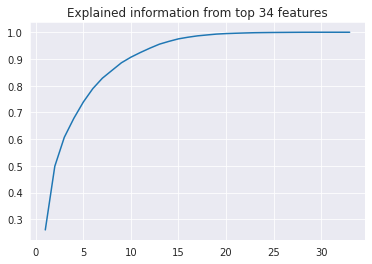

{(4, 0.7388988884161115),
 (9, 0.9066439861958384),
 (14, 0.9752423593194922),
 (19, 0.9949623433105046),
 (24, 0.9991487087020402),
 (29, 0.9999921143488759)}

In [ ]:
clustering.utils.PCA_preview(df_selected_std)

Let's keep the top 15 dimention with only 2.5% loss in the variance

In [ ]:
# these two step will create a agglomerative tree, where root is the root node of this tree
lkg = clustering.clustering.cluster(df_selected_std)
tree = hierarchy.to_tree(lkg)

In [ ]:
root_path = "/content/drive/My Drive/Machine Learning/FlowCAM Files/KORUS/Select Files/**/"
for i,j in enumerate(origin["Image File"].drop_duplicates()):
    if i == 0:
        image_list = extract_from_tif(glob.glob(os.path.join(root_path, j))[0])
    else:
        image_list +=  extract_from_tif(glob.glob(os.path.join(root_path, j))[0])

In [ ]:
clustering.utils.traverse_save_from_dataframe(tree = tree, 
                                              image_list=image_list, 
                                              path_df = origin,
                                              save_path="",
                                              name = "root",
                                              smallest_size = 1000,# 1000 here just for demo
                                              print_mode = True)

making root/right for 15905 images
making root/right/left for 6274 images
making root/right/left/right for 5881 images
making root/right/left/right/left for 3209 images
making root/right/left/right/left/left for 1363 images
making root/right/left/right/left/right for 1846 images
making root/right/left/right/left/right/right for 1304 images
making root/right/left/right/right for 2672 images
making root/right/left/right/right/right for 2632 images
making root/right/left/right/right/right/right for 1958 images
making root/right/left/right/right/right/right/right for 1400 images
making root/right/right for 9631 images
making root/right/right/left for 5041 images
making root/right/right/left/left for 1268 images
making root/right/right/left/right for 3773 images
making root/right/right/left/right/right for 2898 images
making root/right/right/left/right/right/left for 1456 images
making root/right/right/left/right/right/right for 1442 images
making root/right/right/right for 4590 images
maki